# Execute the 20news experiment

In [1]:
import nltk
import warnings
import pandas as pd
import numpy as np

import sklearn.metrics as mtr
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(42)
warnings.filterwarnings('ignore')

# Download the 20news dataset

In [2]:
data_home = '/Users/alfio/Dati/sklearn/'
categories = ['alt.atheism', 'soc.religion.christian', 
              'talk.religion.misc', 'talk.politics.mideast', 'rec.sport.baseball']
data_train = fetch_20newsgroups(subset='train', categories=categories, data_home=data_home)
data_test = fetch_20newsgroups(subset='test', categories=categories, data_home=data_home)

In [6]:
print(data_train.target_names)

['alt.atheism', 'rec.sport.baseball', 'soc.religion.christian', 'talk.politics.mideast', 'talk.religion.misc']


# Set up the competing algorithms

In [7]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC(),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

## Prepare train and test sets

Use a simple tokenization with `nltk.word_tokenize` and vectorize with Tf-Idf.

In [8]:
vectorizer = TfidfVectorizer(tokenizer=nltk.word_tokenize)
X_train = vectorizer.fit_transform(data_train.data)
X_test = vectorizer.transform(data_test.data)
y_train, y_test = data_train.target, data_test.target

## Fit

In [9]:
for model_name, model in models.items():
    print("Training: {}".format(model_name))
    models[model_name].fit(X_train, y_train)

Training: Logistic Regression
Training: Support Vector Machine
Training: Multinomial Naive Bayes
Training: Decision Tree
Training: Random Forest
Training: K-Nearest Neighbors


## Predict

In [10]:
predictions = {}
for model_name, model in models.items():
    print("Predicting: {}".format(model_name))
    predictions[model_name] = model.predict(X_test)

Predicting: Logistic Regression
Predicting: Support Vector Machine
Predicting: Multinomial Naive Bayes
Predicting: Decision Tree
Predicting: Random Forest
Predicting: K-Nearest Neighbors


# Print evaluation metrics

In [11]:
import matplotlib.pyplot as plt

In [13]:
print(mtr.classification_report(y_test, predictions['Support Vector Machine']))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73       319
           1       0.87      0.97      0.92       397
           2       0.78      0.95      0.85       398
           3       0.96      0.83      0.89       376
           4       0.81      0.55      0.65       251

    accuracy                           0.83      1741
   macro avg       0.83      0.80      0.81      1741
weighted avg       0.83      0.83      0.82      1741



In [14]:
E = []
for estimator, y_pred in predictions.items():
    report = mtr.classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    E.append({
        'Model': estimator, 'Accuracy': report['accuracy'],
        'Avg Precision (macro)': report['macro avg']['precision'],
        'Avg Recall (macro)': report['macro avg']['recall'],
        'Avg F1-score (macro)': report['macro avg']['f1-score'],
        'Avg Precision (weighted)': report['weighted avg']['precision'],
        'Avg Recall (weighted)': report['weighted avg']['recall'],
        'Avg F1-score (weighted)': report['weighted avg']['f1-score']
    })
E = pd.DataFrame(E).set_index('Model', inplace=False)

In [15]:
E

,Accuracy,Avg Precision (macro),Avg Recall (macro),Avg F1-score (macro),Avg Precision (weighted),Avg Recall (weighted),Avg F1-score (weighted)
Model,,,,,,,
Logistic Regression,0.820793,0.827682,0.791994,0.795742,0.828353,0.820793,0.813118
Support Vector Machine,0.829983,0.830313,0.804887,0.809078,0.834569,0.829983,0.824782
Multinomial Naive Bayes,0.732338,0.842421,0.675894,0.655891,0.829330,0.732338,0.697841
Decision Tree,0.649627,0.636163,0.625774,0.627947,0.663763,0.649627,0.653715
Random Forest,0.778863,0.806105,0.739435,0.738488,0.802012,0.778863,0.761840
K-Nearest Neighbors,0.644457,0.703107,0.633740,0.639984,0.714915,0.644457,0.653701


In [16]:
p = predictions['Logistic Regression']

In [17]:
cm = mtr.confusion_matrix(y_test, p)

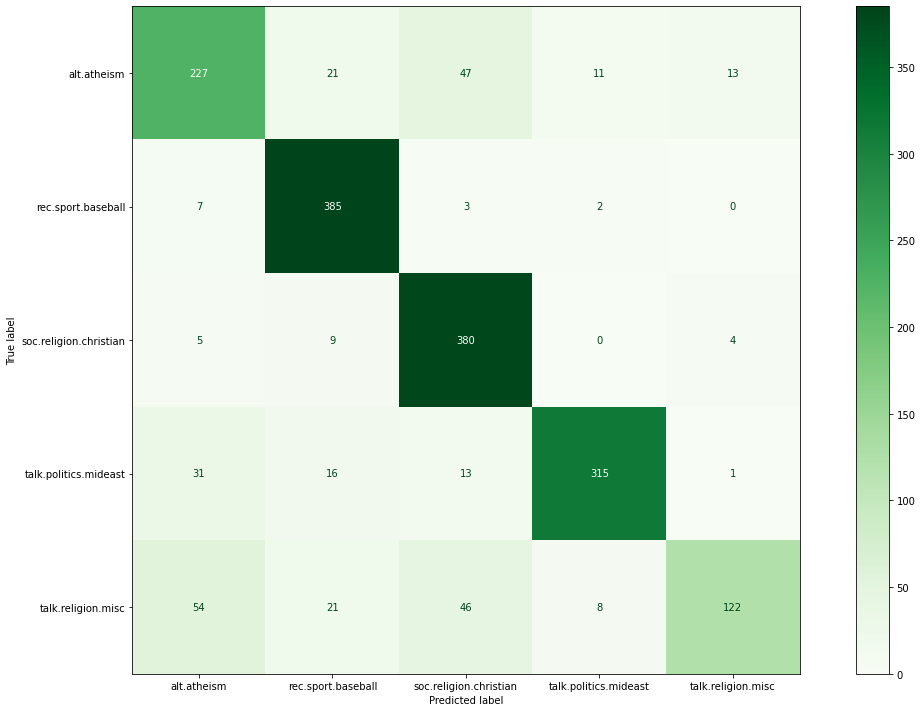

In [18]:
d = mtr.ConfusionMatrixDisplay(cm, data_test.target_names)
fig, ax = plt.subplots(figsize=(16,10))
d.plot(ax=ax, cmap='Greens')
plt.tight_layout()
plt.show()

## Naive ensemble

In [25]:
from collections import Counter

In [23]:
Y = np.array(list(predictions.values()))

In [27]:
e_pred = []
for i in range(Y.shape[1]):
    e_pred.append(Counter(Y[:,i]).most_common()[0][0])

In [29]:
print(mtr.classification_report(y_test, e_pred))

              precision    recall  f1-score   support

           0       0.71      0.72      0.72       319
           1       0.88      0.97      0.92       397
           2       0.76      0.96      0.85       398
           3       0.95      0.85      0.90       376
           4       0.89      0.47      0.61       251

    accuracy                           0.83      1741
   macro avg       0.84      0.80      0.80      1741
weighted avg       0.84      0.83      0.82      1741



In [31]:
Y.T

array([[3, 3, 3, 3, 3, 3],
       [2, 2, 2, 2, 2, 4],
       [1, 1, 1, 1, 1, 3],
       ...,
       [2, 2, 2, 2, 2, 2],
       [1, 1, 2, 4, 3, 0],
       [0, 0, 0, 4, 0, 0]])